In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
import sys
from torch.autograd import Variable
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import multiprocess as mp
import torchvision
import piq
from torch.cuda.amp import custom_bwd, custom_fwd
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import PIL
import scipy
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.feature import corner_harris, corner_subpix, corner_peaks
import pandas

In [21]:
#Data Loading
data = np.load('Full_Data_RealScene_Nonlinear_retrain.npz')['data_fc2']
data2 = np.load('Full_Data_RealScene_Nonlinear_retrain_signs2.npz')['data_fc2']

In [22]:
#speeds = 15, 20, 25, 30, 40, 55, 70, 80

#choosing which signs to pick for nonlinear regression

#15, 25, 30, 70, 80
ids_d1 = [0, 1, 2, 6, 7] 
#20, 40, 55
ids_d2 = [2, 3, 4]

In [23]:
#Train - Validation split 
train_ids = []
test_ids = []
for j in range (89):
    if (j%2 == 1):
        test_ids.append(j)
    else:
        train_ids.append(j)
print(train_ids)
print(test_ids)

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88]
[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87]


In [24]:
#Dataloader generation

norm = 50000.
class Traffic_Sign_Dataset(Dataset):
    def __init__(self, mode) :
        self.mode = mode
        self.data = []
        self.labels = []
        for ik in ids_d1:
            if (mode == 'train'):
                for i in range (89):
                    if i in train_ids:
                        temp = data[89*ik + i].reshape(2)/norm
                        #temp = temp - np.mean(temp)
                        self.data.append(torch.tensor(temp, dtype = torch.float32))
                        self.labels.append(torch.tensor(i, dtype = torch.float32))
            if (mode == 'test'):
                for i in range (89):
                    if i in test_ids:
                        temp = data[89*ik + i].reshape(2)/norm
                        #temp = temp - np.mean(temp)
                        self.data.append(torch.tensor(temp, dtype = torch.float32))
                        self.labels.append(torch.tensor(i, dtype = torch.float32))
        for ik in ids_d2:
            if (mode == 'train'):
                for i in range (89):
                    if i in train_ids:
                        temp = data2[89*ik + i].reshape(2)/norm
                        #temp = temp - np.mean(temp)
                        self.data.append(torch.tensor(temp, dtype = torch.float32))
                        self.labels.append(torch.tensor(i, dtype = torch.float32))
            if (mode == 'test'):
                for i in range (89):
                    if i in test_ids:
                        temp = data2[89*ik + i].reshape(2)/norm
                        #temp = temp - np.mean(temp)
                        self.data.append(torch.tensor(temp, dtype = torch.float32))
                        self.labels.append(torch.tensor(i, dtype = torch.float32))
                
    def __len__(self) :
        return len(self.labels)
        
    def __getitem__(self, idx) :
        return self.data[idx], self.labels[idx]
    
train_data = Traffic_Sign_Dataset('train')
test_data = Traffic_Sign_Dataset('test')

[ 0 22  9 36 32  0 36 36  1  6  9 29 15 30 19 28]


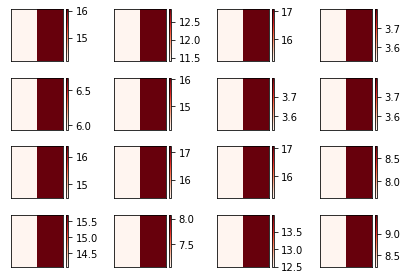

[31 25 30 20 29 28 29 22 25 20 10 34 31 17 17 12]


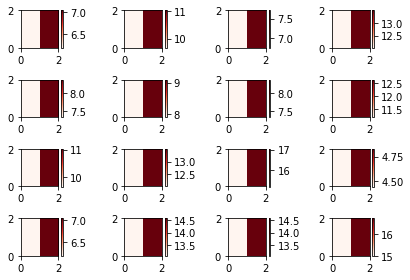

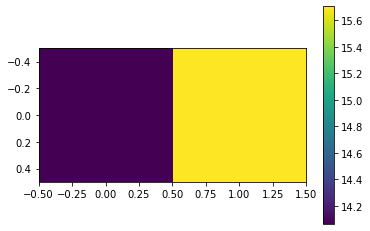

tensor(30.)


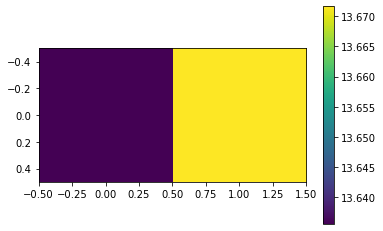

tensor(0.)


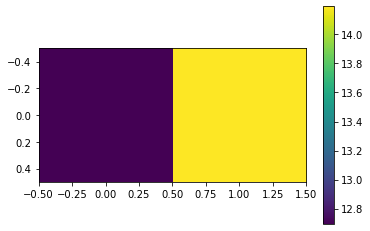

tensor(37.)
360
352


In [25]:
#plotting

recon_scale = 0.8
pixels = 2
pixel_recon = 28
np.random.seed(105)
plots = 16
inds = np.random.randint(0, 40, plots)
print(inds)
fig, axes = plt.subplots(int(np.sqrt(plots)), int(np.sqrt(plots)))
for i in range (int(np.sqrt(plots))):
    for j in range (int(np.sqrt(plots))):
        im = axes[i, j].imshow(train_data[inds[i*int(np.sqrt(plots)) + j]][0].view(1, pixels), interpolation = 'None', \
                       origin='upper', extent=[0, pixels, 0, pixels], cmap = 'Reds')
        plt.colorbar(im, ax = axes[i, j], fraction=0.046, pad=0.04)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
plt.tight_layout()
plt.show()

recon_scale = 0.8
pixels = 2   
inds = np.random.randint(0, 40, size = plots)
print(inds)
fig, axes = plt.subplots(int(np.sqrt(plots)), int(np.sqrt(plots)))
for i in range (int(np.sqrt(plots))):
    for j in range (int(np.sqrt(plots))):
        im = axes[i, j].imshow(test_data[inds[i*int(np.sqrt(plots)) + j]][0].view(1, pixels), interpolation = 'None', \
                       origin='upper', extent=[0, pixels, 0, pixels], cmap = 'Reds')
        plt.colorbar(im, ax = axes[i, j], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

for i,data in enumerate(train_data):
    if(i==15):
        plt.figure()
        plt.imshow(data[0].reshape(1, pixels))
        plt.colorbar()
        plt.show()
        print(data[1])
    if(i==315):
        plt.figure()
        plt.imshow(data[0].reshape(1, pixels))
        plt.colorbar()
        plt.show()
        print(data[1])
    if(i==615):
        plt.figure()
        plt.imshow(data[0].reshape(1, pixels))
        plt.colorbar()
        plt.show()
        print(data[1])
N_train_samp = i + 1
for i,data in enumerate(test_data):
    if(i==18):
        plt.figure()
        plt.imshow(data[0].reshape(1, pixels))
        plt.colorbar()
        plt.show()
        print(data[1])
N_test_samp = i + 1
print(N_train_samp)
print(N_test_samp)

In [26]:
#loading data

batch_size_train = 18
batch_size_test = 352
train_dataset = DataLoader(train_data, batch_size = batch_size_train, shuffle = False)
test_dataset = DataLoader(test_data, batch_size = batch_size_test, shuffle = False)
N_train_batch = int(N_train_samp/batch_size_train)
N_test_batch = int(N_test_samp/batch_size_test)
print(N_train_batch)
print(N_test_batch)

20
1


In [27]:
#Different digital backend
class Decompressor(nn.Module):
    def __init__(self, n_inps : int, n_outs : int, batch : int, dev):
        super(Decompressor, self).__init__()
        self.n_inputs = n_inps
        self.n_outputs = n_outs
        self.device = dev
        self.FC1 = nn.Linear(self.n_inputs, 50, bias = True)
        self.FC2 = nn.Linear(50, 100, bias = True)
        self.FC3 = nn.Linear(100, self.n_outputs, bias = True)
                
    def forward(self, X):
        Y = self.FC1(X)
        Y = torch.relu(Y)
        Y = self.FC2(Y)
        Y = torch.relu(Y)
        Y = self.FC3(Y)
        return Y

In [28]:
#making sure the forward pass is good
recon_scale = 0.8
#Device
dev = 'cuda:0'
device = torch.device(dev if torch.cuda.is_available() else "cpu")
if (device != "cpu") :
    with torch.cuda.device(dev):
        torch.cuda.empty_cache()

torch.manual_seed(78)
dataiter = iter(train_dataset)

model_lin = Decompressor(pixels, 1, batch_size_train, \
                                    device).to(device)
with torch.no_grad():
    digits, labels = dataiter.next()
    digits = digits.to(device)
    labels = labels.to(device)
    print(digits.shape)
    output = model_lin(digits)
    print(output.shape)
    print(labels.shape)
with torch.no_grad():
    criterion = nn.L1Loss(reduction = 'mean')
    loss = criterion(output.view(batch_size_train), labels)
    print(loss)
#loss.backward()

torch.Size([18, 2])
torch.Size([18, 1])
torch.Size([18])
tensor(17.0844, device='cuda:0')


In [29]:
#Training
#optimizer.lr = 1e-4
learn_rate = 5e-3
#learn_rate = 1e-4
# #criterion = nn.L1Loss(reduction = 'sum')
# #criterion = nn.BCEWithLogitsLoss(reduction = 'sum')
# #criterion = nn.BCELoss(reduction = 'sum')
criterion = nn.L1Loss()
optimizer = torch.optim.AdamW(model_lin.parameters(), lr=learn_rate, betas = (0.999, 0.999), \
                             weight_decay = 0.00)
# # optimizer = torch.optim.SGD(model_lin.parameters(), lr=learn_rate, momentum = 1e-4, dampening = 1e-2, \
# #                             weight_decay = 0.00)
Epochs = 1000

if (device != "cpu") :
    with torch.cuda.device(dev):
        torch.cuda.empty_cache()
        
loss_train = []
loss_test = []
acc_train = []
acc_test = []

for epoch in range(Epochs):# loop over the dataset multiple times
#     if (epoch == 1000):
#         optimizer.lr = 1e-2
#     if (epoch == 2000):
#         optimizer.lr = 5e-3
    train_running_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0
    model_lin.train()
    for i, data in enumerate(train_dataset):
        optimizer.zero_grad()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_lin(inputs)
        loss = criterion(outputs.view(batch_size_train), labels)# + lagrangian_loss(model.W_Opt1)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.detach().item()
        #train_acc += get_accuracy(torch.round(outputs), labels)
        #train_acc += get_accuracy(outputs, labels)
    model_lin.eval()
    #acc_train.append(train_acc/N_train_samp)
    loss_train.append(train_running_loss/(N_train_batch))#*batch_size))
    if (epoch%(Epochs/10) == 0) :
        print('Progress:  %d | Loss: %.4f | Accuracy: %.2f'\
              %(100*epoch/Epochs, train_running_loss/(N_train_batch), train_acc/N_train_samp))#*batch_size)))
    t_loss = 0.
    t_acc = 0.
    with torch.no_grad():
        for p, tdata in enumerate(test_dataset):
            t_inputs, t_labels = tdata
            t_inputs = t_inputs.to(device)
            t_labels = t_labels.to(device)
            t_outputs = model_lin(t_inputs)
            t_loss += criterion(t_outputs.view(batch_size_test), t_labels).detach().item()
            #test_acc += get_accuracy(torch.round(t_outputs), t_labels)
            #test_acc += get_accuracy(t_outputs, t_labels)
        #acc_test.append(test_acc/N_test_samp)
        loss_test.append(t_loss/(N_test_batch))
    if (epoch%(Epochs/10) == 0) :
        print('Test Loss: %.6f | Test Accuracy: %.4f' 
          %(t_loss/(N_test_batch), test_acc/N_test_samp))

Progress:  0 | Loss: 36.0947 | Accuracy: 0.00
Test Loss: 35.120655 | Test Accuracy: 0.0000
Progress:  10 | Loss: 6.5805 | Accuracy: 0.00
Test Loss: 6.322445 | Test Accuracy: 0.0000
Progress:  20 | Loss: 5.1815 | Accuracy: 0.00
Test Loss: 4.834179 | Test Accuracy: 0.0000
Progress:  30 | Loss: 4.3175 | Accuracy: 0.00
Test Loss: 4.006069 | Test Accuracy: 0.0000
Progress:  40 | Loss: 4.0555 | Accuracy: 0.00
Test Loss: 3.666005 | Test Accuracy: 0.0000
Progress:  50 | Loss: 3.9710 | Accuracy: 0.00
Test Loss: 3.642082 | Test Accuracy: 0.0000
Progress:  60 | Loss: 3.9210 | Accuracy: 0.00
Test Loss: 3.599765 | Test Accuracy: 0.0000
Progress:  70 | Loss: 3.8862 | Accuracy: 0.00
Test Loss: 3.576670 | Test Accuracy: 0.0000
Progress:  80 | Loss: 3.8775 | Accuracy: 0.00
Test Loss: 3.561005 | Test Accuracy: 0.0000
Progress:  90 | Loss: 3.8254 | Accuracy: 0.00
Test Loss: 3.546022 | Test Accuracy: 0.0000


3.50732421875
3.5091443061828613


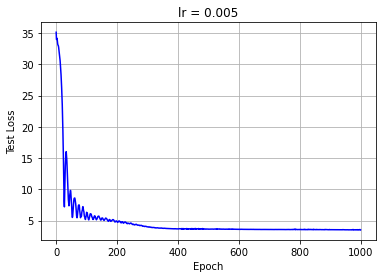

In [30]:
#Loss plot
print(np.min(loss_test))
print(loss_test[-1])
plt.figure(2)
plt.title(f'lr = {learn_rate}')
plt.plot(np.array(loss_test), 'b')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
#plt.yscale('log')
plt.grid()
plt.show()

In [31]:
dataiter = iter(test_dataset)

with torch.no_grad():
    digits, labels = dataiter.next()
    digits = digits.to(device)
    labels = labels.to(device)
    print(digits.shape)
    output = model_lin(digits)

torch.Size([352, 2])


In [32]:
true_angles = labels.detach().cpu().numpy()
pred_angles = output.view(batch_size_test).detach().cpu().numpy()

In [33]:
print(np.max(np.abs(true_angles - pred_angles)))

28.908276


In [34]:
max_err = np.max(np.abs(true_angles - pred_angles))

In [42]:
colors = ['royalblue', 'g', 'r', 'magenta', 'cyan', 'k', 'yellow', 'darkorange']
signs = ['15', '25', '30', '70', '80', '20', '40', '55']

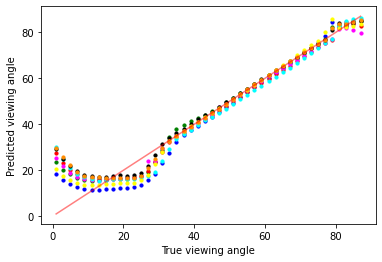

In [40]:
#Final Figure plot - all signs
plt.figure()
plt.xlabel('True viewing angle')
plt.ylabel('Predicted viewing angle')
plt.plot(true_angles, true_angles, 'r', alpha = 0.5)
for i in range (8):
    plt.scatter(true_angles[44*i:44*(i + 1)], pred_angles[44*i:44*(i + 1)], s = 10, c = colors[i])
plt.show()

In [ ]:
#Below is the code for one sign

In [128]:
true_angles70 = np.copy(true_angles)
pred_angles70 = np.copy(pred_angles)

In [41]:
SMALL_SIZE = 10
MEDIUM_SIZE = 20
BIGGER_SIZE = 16

plt.rcParams["font.family"] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

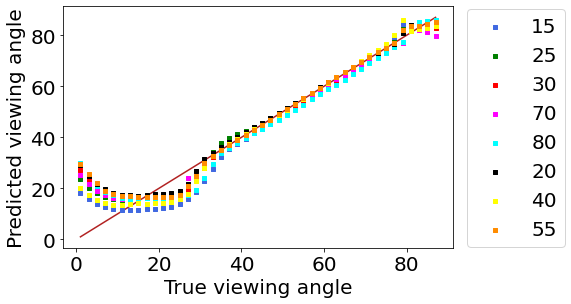

In [58]:
fig, ax = plt.subplots(1, 1, figsize = (7, 5))
plt.xlabel(r'True viewing angle')
plt.ylabel(r'Predicted viewing angle')
for i in range (8):
    plt.scatter(true_angles[44*i:44*(i + 1)], pred_angles[44*i:44*(i + 1)], s = 20, c = colors[i], \
                marker = 's', label = signs[i], zorder = 2)
plt.plot(true_angles, true_angles, 'firebrick', alpha = 1, zorder = 1)
ratio = 1/1.618
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
plt.legend(bbox_to_anchor = (1.01, 1.03))
plt.savefig('Nonlinear_regression_all.svg', dpi = 1200, format='svg')#, backend = 'svg')
#plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1)
plt.title('Speed Limit - 70')
plt.xlabel(r'True viewing angle')
plt.ylabel(r'Predicted viewing angle')
plt.scatter(true_angles70, pred_angles70, s = 20, c = 'royalblue', marker = 's', label = 'prediction', zorder = 2)
plt.plot(true_angles70, true_angles70, 'firebrick', alpha = 1, label = ' = ', zorder = 1)
ratio = 1/1.618
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
plt.legend(bbox_to_anchor = (0.4, 0.4))
plt.savefig('Nonlinear_regression_70.svg', dpi = 1200, format='svg')#, backend = 'svg')
plt.show()

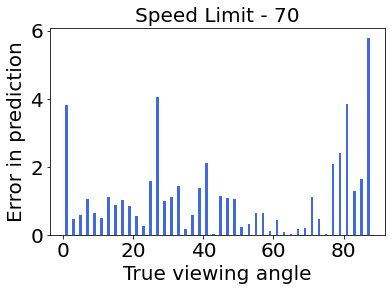

In [147]:
fig, ax = plt.subplots(1, 1)
plt.title('Speed Limit - 70')
plt.xlabel(r'True viewing angle')
plt.ylabel(r'Error in prediction')
plt.bar(true_angles70, np.abs(pred_angles70 - true_angles70), color ='royalblue', width = 0.8)
ratio = 1/1.618
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
plt.savefig('Nonlinear_regression_70_error.svg', dpi = 1200, format='svg')#, backend = 'svg')
plt.show()